In [2]:
import numpy as np
import pandas as pd
from   scipy.stats import norm
from src.config import SRC,BLD
from estimagic import maximize
from scipy.stats import pearsonr as pear
import matplotlib.pyplot as plt

data =  pd.read_pickle( BLD /"data"/"prepared_data.pkl" )
ind = pd.read_csv( SRC/"replication_files"/"original_data"/"ind_to_keep.csv")

def load_args(data,spec):

    """

    Args:
        data (pd.DataFrame): Dataset containing observations for 71 individuals
        spec(int): specification parameter

    Returns:
        args (pd.DataFrame): Arguments(Necessary Columns) for LL-Function

    """
    netdistance = np.array(data["netdistance"])
    wage = np.array(data["wage"])
    today = np.array(data["today"])
    prediction = np.array(data["prediction"])
    pb = np.array(data["pb"])
    effort = np.array(data["effort"])
    ind_effort10 = np.array(data["ind_effort10"])
    ind_effort110 = np.array(data["ind_effort110"])

    args = pd.DataFrame(
        {
            "netdistance": netdistance,
            "wage": wage,
            "today": today,
            "prediction": prediction,
            "pb": pb,
            "effort": effort,
            "ind_effort10": ind_effort10,
            "ind_effort110": ind_effort110,
            "spec" : spec
        }
    )

    return args

def start_params(spec):
    ## same as before just with option to leave out alpha if needed
    if spec != 4:
        parm = [1, 1, 1, 2, 250, 50]
        init_parm = pd.DataFrame(
        parm,
        columns=["value"],
        index=["beta", "betahat", "delta", "gamma", "phi", "sigma"],
        )
    else :
        parm = [1, 1, 1, 2, 250, 3, 50]
        init_parm = pd.DataFrame(
        parm,
        columns=["value"],
        index=["beta", "betahat", "delta", "gamma", "phi", "alpha", "sigma"],
        )
    return init_parm


In [3]:
def loglike(params,args):
    
    predchoice = (
        (
            params.loc["phi", "value"]
            * (params.loc["delta", "value"] ** args["netdistance"])
            * (params.loc["beta", "value"] ** args["today"])
            * (params.loc["betahat", "value"] ** args["prediction"])
            * args["wage"]
        )
        ** (1 / (params.loc["gamma", "value"] - 1))
    )

    if args["spec"].all() == 4: predchoice = predchoice - args["pb"] * params.loc["alpha", "value"]
    
    prob = (
        (1 - args["ind_effort10"] - args["ind_effort110"])
        * norm.pdf(args["effort"], predchoice, params.loc["sigma", "value"])
        + args["ind_effort10"]
        * (1 - norm.cdf((predchoice - args["effort"]) / params.loc["sigma", "value"]))
        + args["ind_effort110"]
        * norm.cdf((predchoice - args["effort"]) / params.loc["sigma", "value"])
    )   
    index_p0 = [i for i in range(0,len(prob)) if prob[i]==0] 
    index_p1 = [i for i in range(0,len(prob)) if prob[i]==1]
    
    for i in index_p0:
        prob[i] = 1E-4
        
    for i in index_p1:
        prob[i] = 1 - 1E-4
    
    ll = np.sum(np.log(prob)) # log likelihood
    
    return { "value" : ll}


def getind(dataset, wid, spec):
    dataset_ind = dataset[dataset.wid == wid]
    if spec == 2: dataset_ind = dataset_ind[dataset_ind.decisiondatenum < 4]  # second column specification
    if spec == 3: dataset_ind = dataset_ind[dataset_ind.decisiondatenum >= 4] # third column specification    
    return dataset_ind

def estimate_individual_ll(wid,dataset,spec,params):
    dt_ind = getind(dataset, wid, spec) 
    args_ind = load_args(dt_ind,spec)
    sol = maximize(
            criterion=loglike,
            params=params,
            algorithm='scipy_neldermead',
            criterion_kwargs={"args": args_ind},
            algo_options= {"stopping_max_iterations": 2500}
            )
    return sol["solution_x"]


def estimate(dataset,spec):
    params = start_params(spec)
    results = [estimate_individual_ll(wid,dataset,spec,params) for wid in np.unique(dataset.wid)]
    return results

""" def estimate(dataset, spec):
    
    params = start_params(spec)
    sol_param, sol_wid = [], []
    
    for wid in np.unique(dataset.wid):      
        
        dt_ind = getind(dataset, wid, spec) 
        args_ind = load_args(dt_ind,spec)
                
        sol = maximize(
            criterion=loglike,
            params=params,
            algorithm='scipy_neldermead',
            criterion_kwargs={"args": args_ind},
            algo_options= {"stopping_max_iterations": 2500}
            )

        sol_param.append(sol["solution_x"])
        sol_wid.append(wid)
            
        if wid == 25.0: print("25% done")
        if wid == 50.0: print("50% done")
        if wid == 75.0: print("75% done")
        if wid == 100.0: print("100% done")

    return sol_param, sol_wid """


res_1 = estimate(data,1)


## Likelihood Fct

In [8]:
param1= pd.DataFrame(res_1, columns = ["beta","betahat","delta", "gamma","phi","sigma"] )
param1

,beta,betahat,delta,gamma,phi,sigma
0,0.371237,1.248034,0.981711,1.553893,493.815981,144.223244
1,0.601578,0.880807,1.082842,1.563296,121.434370,500.374374
2,1.501173,1.118967,0.985498,1.681685,226.273195,60.417215
3,0.603522,0.910384,1.011114,2.619844,2589.414611,8.582973
4,0.257555,1.030227,1.091816,4.337794,145580.235663,11.856098
...,...,...,...,...,...,...
67,1.129434,1.102805,0.996165,1.476885,35.158937,12.113484
68,1.162507,1.211876,1.038343,2.631792,366.598600,-0.457556
69,0.918411,0.977901,0.987929,2.497215,4140.425957,28.666942
70,0.446725,0.919346,1.058292,2.449572,432.179697,26.044353


## Create Table 

array([ 9.38571362e-01,  3.71236929e-01,  6.01578064e-01,  1.50117286e+00,
       -1.49360897e-07,  2.18518409e+00,  6.03522262e-01,  2.57554938e-01,
        7.41800081e-01,  7.23960726e-01,  1.07820779e+00,  4.22897785e-01,
        8.03297730e-01, -6.71802952e-07,  4.37699051e-01,  9.40920263e-01,
        6.63753097e-01,  1.25266086e+00,  3.60098224e-01,  1.18778417e+00,
        1.30722015e+00,  1.00025211e+00,  1.01004866e+00,  1.01645928e+00,
        1.02373274e+00,  9.09485539e-01,  9.73954264e-01,  9.35322724e-01,
        8.10438316e-01,  8.83999145e-01,  9.38991619e-01,  1.31852327e+00,
        7.87161164e-01,  1.17229233e+00,  9.57539986e-01,  1.25235451e+00,
        9.09917183e-01,  9.39088837e-01,  1.18743289e+00,  1.05813944e+00,
        5.00623159e-01,  9.53257866e-02,  3.19442188e-01,  7.67332261e-01,
        8.12058236e-01,  1.14996248e+00,  4.64478206e-01,  1.22170739e+00,
        1.12517331e+00,  6.78356124e-01,  6.10662477e-01,  3.33761255e-01,
        9.52318477e-01,  

In [68]:
# Load the dataset containing the wid of the individuals to keep in the different specifications. We created this csv file by running
# their "03MergeIndMLEAndConstructMainSample.do" do-file. This do-file returns 67 individuals to keep for specification 4, while in the 
# paper the number of individuals is 68. We do not know the reason for this difference.

ind_keep = pd.read_csv(SRC /"replication_files"/ "original_data"/"ind_to_keep.csv")   # 4 columns, each containing individuals to keep in each specification

# keep parameters only for individuals in ind_keep

# For column 1:
mc1 = pd.DataFrame({'wid':np.unique(data.wid),'b':b1,'bh':bh1,'d':d1,'g':g1})
dc1 = mc1[mc1.wid.isin(ind_keep.wid_col1)]

# For column 2:
mc2 = pd.DataFrame({'wid':np.unique(data.wid),'b':b2,'bh':bh2,'d':d2,'g':g2})
dc2 = mc2[mc2.wid.isin(ind_keep.wid_col2)]

# For column 3:
mc3 = pd.DataFrame({'wid':np.unique(data.wid),'b':b3,'bh':bh3,'d':d3,'g':g3})
dc3 = mc3[mc3.wid.isin(ind_keep.wid_col3)]

# For column 4:
mc4 = pd.DataFrame({'wid':np.unique(data.wid),'b':b4,'bh':bh4,'d':d4,'g':g4,'a':a4})
dc4 = mc4[mc4.wid.isin(ind_keep.wid_col4)]

from IPython.display import display

pnames = ["mean(β)", "median(β)", "sd(β)", "mean(β_h)", "median(β_h)", "sd(β_h)", "mean(δ)", "median(δ)", "sd(δ)",
          "mean(γ)", "median(γ)", "sd(γ)","mean(α)", "median(α)", "sd(α)", "P[β]<1", "P[β_h]<1", 'r(β,β_h)','p-value r(β,β_h)',
          'Observations']
col1 = np.round([np.mean(dc1.b), np.median(dc1.b), np.std(dc1.b),np.mean(dc1.bh), np.median(dc1.bh), np.std(dc1.bh),
                np.mean(dc1.d), np.median(dc1.d), np.std(dc1.d),np.mean(dc1.g), np.median(dc1.g), np.std(dc1.g),
                0,0,0,np.round(np.mean(dc1.b<1),2),np.round(np.mean(dc1.bh<1),2),np.corrcoef(dc1.b,dc1.bh)[0,1],
                np.round(pear(dc1.b, dc1.bh)[1],3),len(dc1.b)],3)
col2 = np.round([np.mean(dc2.b), np.median(dc2.b), np.std(dc2.b),np.mean(dc2.bh), np.median(dc2.bh), np.std(dc2.bh),
                np.mean(dc2.d), np.median(dc2.d), np.std(dc2.d),np.mean(dc2.g), np.median(dc2.g), np.std(dc2.g),
                0,0,0,np.round(np.mean(dc2.b<1),2),np.round(np.mean(dc2.bh<1),2),np.corrcoef(dc2.b,dc2.bh)[0,1],
                np.round(pear(dc2.b, dc2.bh)[1],3),len(dc2.b)],3)
col3 = np.round([np.mean(dc3.b), np.median(dc3.b), np.std(dc3.b),np.mean(dc3.bh), np.median(dc3.bh), np.std(dc3.bh),
                np.mean(dc3.d), np.median(dc3.d), np.std(dc3.d),np.mean(dc3.g), np.median(dc3.g), np.std(dc3.g),
                0,0,0,np.round(np.mean(dc3.b<1),2),np.round(np.mean(dc3.bh<1),2),np.corrcoef(dc3.b,dc3.bh)[0,1],
                np.round(pear(dc3.b, dc3.bh)[1],3),len(dc3.b)],3)
col4 = np.round([np.mean(dc4.b), np.median(dc4.b), np.std(dc4.b),np.mean(dc4.bh), np.median(dc4.bh), np.std(dc4.bh),
                np.mean(dc4.d), np.median(dc4.d), np.std(dc4.d),np.mean(dc4.g), np.median(dc4.g), np.std(dc4.g),
                np.mean(dc4.a), np.median(dc4.a), np.std(dc4.a),np.round(np.mean(dc4.b<1),2),np.round(np.mean(dc4.bh<1),2),
                np.corrcoef(dc4.b,dc4.bh)[0,1],np.round(pear(dc4.b, dc4.bh)[1],3),len(dc4.b)],3)
at1 = pd.DataFrame({"":pnames, "Primary Estimation":col1, "Early Decisions":col2, "Later Decisions":col3, "Proj. Bias":col4})

print("Table 2: Summary statistics for individual structural estimates")
display(at1)

Table 2: Summary statistics for individual structural estimates


,,Primary Estimation,Early Decisions,Later Decisions,Proj. Bias
0,mean(β),0.808,0.874,0.910,0.817
1,median(β),0.849,0.925,0.937,0.880
2,sd(β),0.305,0.345,0.245,0.322
3,mean(β_h),1.016,1.007,0.998,1.024
4,median(β_h),0.999,0.996,0.987,1.018
5,sd(β_h),0.187,0.179,0.106,0.161
6,mean(δ),1.018,1.012,1.008,1.017
7,median(δ),1.008,1.007,1.003,1.008
8,sd(δ),0.036,0.024,0.028,0.040
9,mean(γ),2.136,2.151,2.002,2.185


Distribution of beta for column 1


(0.0, 1.8)

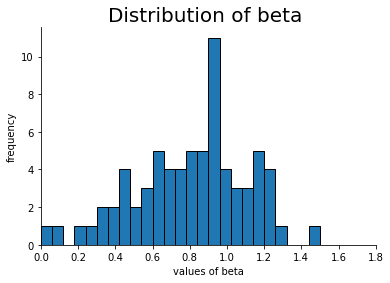

In [71]:
print('Distribution of beta for column 1')
n_bins = 25
count, bins, ignored = plt.hist(dc1.b, n_bins, edgecolor='black')
plt.title('Distribution of beta ', fontsize=20)
plt.ylabel(r'frequency')
plt.xlabel(r'values of beta')
plt.xlim([0, 1.8])